In [1]:
using PyPlot
using Distributions
using StatsBase
using GWASTools
using HDF5

In [2]:
dosage = h5read("../data/samplepop5.hdf5", "dosage");

In [ ]:
size(dosage)

In [ ]:
showmatrix(dosage, cmap="GnBu", minmax=[0,2]);

In [ ]:
COR =  cor(dosage,2)
LD = COR.^2 .> 0.1
showmatrix(COR, cmap="bwr", minmax=[-1,1]);
showmatrix(LD, minmax=[0,1]);

In [ ]:
LDscore = vec(sum(COR.^2,2))

In [ ]:
GWASTools.zygotefreq(dosage)

In [ ]:
function riskscore(dosage::Matrix{Int8}, risk::Vector{Float64})    
    Nind = size(dosage)[2]
    score = Array(Float64, Nind) 
    for i in 1:Nind
        score[i] = dot(risk, dosage[:,i])
    end 
    score
end

function assign_cases(score::Vector{Float64}, casesfraction::Float64)
    @assert casesfraction < 1.0
    Ncases = Int(round(casesfraction * length(score)))
    casesind = sortperm(score, rev=true)[1:Ncases]
    cases = zeros(Bool,length(score))
    cases[casesind] = true 
    cases
end

function set_random_phenotype(dosage::Matrix{Int8}, risksnpfraction::Float64, casesfraction::Float64)
    Nsnp, Nind = size(dosage)
    Nrisk = Int(round(risksnpfraction*Nsnp))
    risk = zeros(Float64, Nsnp)
    risk[sample(1:Nsnp, Nrisk, replace=false)] =  rand(Nrisk) + 1

    score = riskscore(dosage, risk)
    cases = assign_cases(score, casesfraction)
    cases, risk
end

function set_random_phenotype_pleiotropic(dosage::Matrix{Int8}, risksnpfraction::Float64, casesfraction::Float64, overlap::Float64)
    Nsnp, Nind = size(dosage)
    Nrisk = Int(round(risksnpfraction*Nsnp))
    Nrisk_overlap = Int(round(overlap*Nrisk))
    risksnps = sample(1:Nsnp, 2*Nrisk - Nrisk_overlap, replace=false)
    
    risk1 = zeros(Float64, Nsnp)
    risk2 = zeros(Float64, Nsnp)
    risk1[risksnps[1:Nrisk]] = rand(Nrisk) + 1
    risk2[risksnps[end-Nrisk+1:end]] = rand(Nrisk) + 1

    score1 = riskscore(dosage, risk1)
    cases1 = assign_cases(score1, casesfraction)
    score2 = riskscore(dosage, risk2)
    cases2 = assign_cases(score2, casesfraction)
    
    cases1, risk1, cases2, risk2
end

cases1, risk1, cases2, risk2 = set_random_phenotype_pleiotropic(dosage, 0.005, 0.05, 0.75);
zscores1 = GWAS(dosage, cases1);
zscores2 = GWAS(dosage, cases2);

manhattanplot(zscores1, risk1 .> 1.0);
zhist(zscores1);

In [16]:
cases = rand(size(dosage)[2]).> 0.5;

calculating GWAS z-scores ... 99%  ETA: 0:00:00

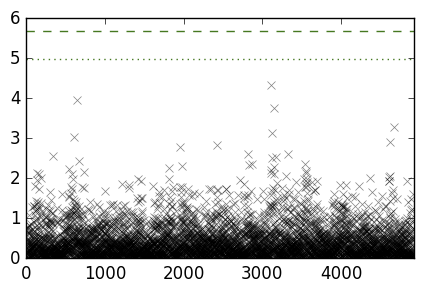

calculating GWAS z-scores ...100% Time: 0:00:06


7

In [17]:
mockzscores = GWAS(dosage,cases);
manhattanplot(mockzscores);
sum(isnan(mockzscores))

In [9]:
probhist(z2p(zscores))
probhist(z2p(mockzscores))

LoadError: LoadError: UndefVarError: zscores not defined
while loading In[9], in expression starting on line 1

In [ ]:
for a in 2:2
    println(a)
end

In [ ]:
function stratify_mask(scores::Vector{Float64}, N::Integer)
    @assert N >= 2
    lim = linspace(minimum(scores), maximum(scores), N+1)
    res = BitArray(length(scores), N)
    res[:,1] = scores .<= lim[2]
    for i in 2:N
        res[:,i] = lim[i] .< scores .<= lim[i+1]
    end
    res
end

function mask_cummulative_lim(scores::Vector{Float64}, lim::AbstractVector)
    mask = BitArray(length(scores), length(lim)+1)
    mask[1,:] = true
    for i in 2:size(mask)[2]
        mask[:,i] = scores .<= lim[i]
    end
    mask
end

function zz_scratterplot(zscores1::Vector{Float64}, zscores2::Vector{Float64}; 
    cscores::Vector{Float64}=Float64[],cscoreN::Int=10, highlight::AbstractVector{Bool}=BitArray(0))
    N = length(zscores1)
    highlight = length(highlight)==0 ?  BitArray(N)*false : highlight
    
    @assert N == length(zscores2) == length(highlight)
    @assert N == length(cscores) || length(cscores) == 0
    
    #Bonf1 = (0.05/N)
    #Bonf2 = (0.01/N)
    
    fig = plt[:figure](figsize=(7,7))
    ax = fig[:add_subplot](111)
    ax[:set_aspect]("equal")
    maxlim = 1.03*max( 1, maximum(zscores1), maximum(zscores2))
    minlim = 1.03*min(-1, minimum(zscores1), minimum(zscores2))
    ax[:set_xlim]([minlim,maxlim])
    ax[:set_ylim]([minlim,maxlim])
    ax[:plot]([0,0], [minlim,maxlim], "-k", alpha=0.5)
    ax[:plot]([minlim,maxlim], [0,0], "-k", alpha=0.5)

    if length(cscores) == 0
        ax[:plot](zscores1[~highlight], zscores2[~highlight], "o", color="0.8", alpha=0.8)
        ax[:plot](zscores1[highlight], zscores2[highlight], "^", color=GWASTools.ORANGE, alpha=1)
    else
        cmap = ColorMap("viridis")
        #display(cmap)
        mask = stratify_mask(cscores,cscoreN)
        mask[highlight,:] = false
        val = linspace(0, 1, cscoreN)
        for i in 1:cscoreN           
            ax[:plot](zscores1[mask[:,i]],zscores2[mask[:,i]], "o", color=cmap(val[i]), alpha=0.8)
        end
        ax[:plot](zscores1[highlight], zscores2[highlight], "^", color=GWASTools.ORANGE,  alpha=1)
    end
end
zz_scratterplot(zscores1,zscores2,highlight=risk2.>0)

In [ ]:
lengtsize(zscores)

In [ ]:
function add_neglogp_to_qq!(ax::PyCall.PyObject, neglogp::Vector{Float64}, color)
    N = length(neglogp)
    x = -log10(reverse(uniform_quantile(N)))
    y = sort(neglogp)
    xmax = x[end] * 1.05    
    if xmax > ax[:get_xlim]()[2]
        ax[:set_ylim]([0,1.6*xmax])
        ax[:set_xlim]([0,xmax])
    end
    ax[:plot](x,y,".", color=color)
end

function qqplot(pval::Vector{Float64}, cscores)    
    fig = plt[:figure](figsize=(7,7))
    ax = fig[:add_subplot](111)
    ax[:set_aspect]("equal")
    
    add_neglogp_to_qq!(ax::PyCall.PyObject, -log10(z2p(zscores)), GWASTools.RED)
    range = ax[:get_xlim]()
    ax[:plot](range,range,"--k")
end

qqplot(zscores1)
qqplot(zscores2)

#qqplot(mockzscores)